Visual Transformers
<center><img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png" alt="Alternative text"/></center> 
<center><figcaption>Fig 1. Dosovitskiy, Alexey, et al. "An image is worth 16x16 words: Transformers for image recognition at scale."https://arxiv.org/pdf/2010.11929.pdf. </figcaption></center>                 


Transformers have been studied in the context of sequence-to-sequence modelling applications like natural language processing (NLP). Their superior performance to LSTM-based Recurrant neural network gained them a powerful reputation, thanks to their ability to model long sequences. A couple of years ago, transformers have been adapted to the [visual domain](https://arxiv.org/abs/2010.11929) and suprisingly demonstrated better performance compared to the long standing convolutional neural networks conditioned to large-scale datasets. Thanks to their ability to capture global semantic relationships in an image, unlike, CNNs which capture local information within the vicinty of the convolutional kernel window.

This repository implements the building blocks of visual transformers (LightViT). Afterwards, trains them on classification task using MNIST and Fashion-MNIST datasets.


In [49]:
#VIPUL PATIL
"""The standard Transformer receives as input a 1D
sequence of token embeddings. To handle 2D images, we reshape the image x ∈ R(H×W×C) into a
sequence of flattened 2D patches xp ∈R(N×(P^2·C))
- , where (H, W) is the resolution of the original image, 
- C is the number of channels, 
- (P, P) is the resolution of each image patch, 
- and N = HW/P^2 is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.
- The Transformer uses constant latent vector size D through all of its layers, 
- so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). 
- We refer to the output of this projection as the patch embeddings."""

'The standard Transformer receives as input a 1D\nsequence of token embeddings. To handle 2D images, we reshape the image x ∈ R(H×W×C) into a\nsequence of flattened 2D patches xp ∈R(N×(P^2·C))\n- , where (H, W) is the resolution of the original image, \n- C is the number of channels, \n- (P, P) is the resolution of each image patch, \n- and N = HW/P^2 is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.\n- The Transformer uses constant latent vector size D through all of its layers, \n- so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). \n- We refer to the output of this projection as the patch embeddings.'

In [67]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math


def extract_patches(images, num_patches_per_dim=7):
    """
    Extract patches from images and return them in the desired shape.

    Parameters:
    - images (torch.Tensor): Input tensor of shape (B, C, H, W)
    - num_patches_per_dim (int): Number of patches along one dimension (P). Default is 7.

    Returns:
    - torch.Tensor: Output tensor of shape (B, P*P, (H*W)/(P*P) * C)
    """
    B, C, H, W = images.shape
    patch_size_h = H // num_patches_per_dim
    patch_size_w = W // num_patches_per_dim
    
    assert H % num_patches_per_dim == 0 and W % num_patches_per_dim == 0, "Image dimensions must be divisible by the number of patches per dimension."
    
#     patches = []
#     for i in range(num_patches_per_dim):
#         for j in range(num_patches_per_dim):
#             patch = images[:, :, i * patch_size_h:(i + 1) * patch_size_h, j * patch_size_w:(j + 1) * patch_size_w]
#             patches.append(patch)

    patches = F.unfold(images, kernel_size=(patch_size_h, patch_size_w), stride=(patch_size_h, patch_size_w))
    #print(patches.shape)
    
    # Reshape the patches
    patches = patches.permute(0, 2, 1)
    patches = patches.view(B, -1, patch_size_h * patch_size_w * C)
    
    return patches


def get_pos_embeddings(n_patches, d):
        """
        Generate sinusoidal positional embeddings for each patch.
        
        Returns:
        - torch.Tensor: Positional embeddings of shape (P*P + 1, d) -> extra dim for classification token 
        """
        num_patches = n_patches * n_patches
        position = torch.arange(num_patches + 1, dtype=torch.float).unsqueeze(1) # adding patch size dimension
        div_term = torch.exp(torch.arange(0, d, 2).float() * (-math.log(10000.0) /d))
        
        pos_emb = torch.zeros(num_patches + 1, d)
        pos_emb[:, 0::2] = torch.sin(position * div_term)
        pos_emb[:, 1::2] = torch.cos(position * div_term)
        
        return pos_emb.unsqueeze(0)  # adding batch dimension
    

class MHSA(nn.Module):
    def __init__(self, d, n_heads=2): # d: dimension of embedding spacr, n_head: dimension of attention heads
        super(MHSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        self.head_dim = d // n_heads
        
        self.query = nn.Linear(self.head_dim, self.head_dim)
        self.key = nn.Linear(self.head_dim, self.head_dim)
        self.value = nn.Linear(self.head_dim, self.head_dim)
        self.out_proj = nn.Linear(d, d)
        
    def forward(self, x):
        B, N, D = x.shape # Sequences has shape (N, seq_length, token_dim)
        x = x.view(B, N, self.n_heads, self.head_dim)  # Shape is transformed to   (N, seq_length, n_heads, token_dim / n_heads)
        Q = self.query(x) 
        #print(Q.shape)
        K = self.key(x)
        V = self.value(x)
        
        QK_T = torch.einsum('bnhd,bmhd->bhnm', Q, K)
        #print(QK_T.shape)
        scale = math.sqrt(self.head_dim)
        attn = torch.softmax(QK_T / scale, dim=-1)
        #print(attn.shape)
        attn_out = torch.einsum('bhnm,bmhd->bnhd', attn, V)
        
        attn_out = attn_out.reshape(B, N, D) # And finally we return back    (N, seq_length, item_dim)  
        out = self.out_proj(attn_out)
        
        return out 

    
class ViTEncoder(nn.Module):
    def __init__(self, hidden_d, n_heads):
        super(ViTEncoder, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d) # Add Layer-Norm
        self.mhsa = MHSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d) # Add another Layer-Norm
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, 4 * hidden_d),
            nn.GELU(),
            nn.Linear(4 * hidden_d, hidden_d)
        )


    def forward(self, x):
        out = x + self.mhsa(self.norm1(x)) # norm1->mhsa->+Residual
        out = out + self.mlp(self.norm2(out))  # norm2->mlp->+Residual
        return out

    
    
class LightViT(nn.Module):
    def __init__(self, image_shape, n_patches=7, n_blocks=2, d=8, n_heads=2, num_classes=10):
        super(LightViT, self).__init__()
        B, C, H, W = image_shape
        self.patch_size_h = H//n_patches
        self.patch_size_w = W//n_patches
        self.d = d
        self.n_patches = n_patches

        ## Class Member

        ## Linear Mapping
        self.linear_map = nn.Linear(self.patch_size_h * self.patch_size_w * C, d)

        ## Learnable Parameter
        self.cls_token =  nn.Parameter(torch.randn(1, 1, d))

        ## Positional embedding
        self.pos_embed = nn.Parameter(get_pos_embeddings(n_patches, d), requires_grad=False)
        

        ## Encoder blocks
        self.encoders = nn.ModuleList([ViTEncoder(d, n_heads) for _ in range(n_blocks)])

        # Classification Head
        self.classifier = nn.Linear(d, num_classes)
    
    
    def forward(self, images):
        B = images.size(0)
        
        ## Extract patches
        img_patches = extract_patches(images, self.n_patches)

        ## Linear mapping
        patches = self.linear_map(img_patches)

        ## Add classification token
        """Expand the classifier token to match the batch size and concatenate it to the patches"""
        cls_tokens = self.cls_token.expand(B, -1, -1)
        tokens = torch.cat((cls_tokens, patches), dim=1)

        ## Add positional embeddings
        positional_embedding = self.pos_embed.expand(B, -1, -1)
        tokens += positional_embedding

        # Pass through encoder blocks
        for encoder in self.encoders:
            tokens = encoder(tokens)

        # Get classification token
        cls_token_final = tokens[:, 0]

        # Pass through classifier
        logits = self.classifier(cls_token_final)

        return logits



# Test the LightViT model with a random image tensor
if __name__ == '__main__':
    image = torch.randn(7, 3, 224, 224)  # Example input with batch size 7 and image size 224x224
    model = LightViT(image.shape)
    output = model(image)
    print(output.shape)  # Should print torch.Size([7, 10])

torch.Size([7, 10])


## 1. Image Patches and Linear Mapping

### A) Image Patches
Transfomers were initially created to process sequential data. In case of images, a sequence can be created through extracting patches. To do so, a crop window should be used with a defined window height and width. The dimension of data is originally in the format of *(B,C,H,W)*, when transorfmed into patches and then flattened we get *(B, PxP, (HxC/P)x(WxC/P))*, where *B* is the batch size and *PxP* is total number of patches in an image. In this example, P=7. 


*Output*: A function that extracts image patches. The output format should have a shape of (B,49,16). The function will be used inside *LightViT* class.

In [41]:

def extract_patches(images, num_patches_per_dim=7):
    """
    Extract patches from images and return them in the desired shape.

    Parameters:
    - images (torch.Tensor): Input tensor of shape (B, C, H, W)
    - num_patches_per_dim (int): Number of patches along one dimension (P). Default is 7.

    Returns:
    - torch.Tensor: Output tensor of shape (B, P*P, (H*W)/(P*P) * C)
    """
    B, C, H, W = images.shape
    patch_size_h = H // num_patches_per_dim
    patch_size_w = W // num_patches_per_dim
    
    assert H % num_patches_per_dim == 0 and W % num_patches_per_dim == 0, "Image dimensions must be divisible by the number of patches per dimension."
    
#     patches = []
#     for i in range(num_patches_per_dim):
#         for j in range(num_patches_per_dim):
#             patch = images[:, :, i * patch_size_h:(i + 1) * patch_size_h, j * patch_size_w:(j + 1) * patch_size_w]
#             patches.append(patch)

    patches = F.unfold(images, kernel_size=(patch_size_h, patch_size_w), stride=(patch_size_h, patch_size_w))
    #print(patches.shape)
    
    # Reshape the patches
    patches = patches.permute(0, 2, 1)
    patches = patches.view(B, -1, patch_size_h * patch_size_w * C)
    
    return patches

torch.Size([2, 27, 49])
torch.Size([2, 49, 27])


### B) Linear Mapping

Afterwards, the input are mapped using a linear layer to an output with dimension *d* i.e. *(B, PxP, (HxC/P)x(WxC/P))* &rarr; *(B, PxP, d)*. The variable d can be freely chosen, however, we set here to 8. 

*Output*: A linear layer should be added inside *LightViT* class with the correct input and output dimensions, the output from the linear layer should have a dimension of (B,49,8). 

## 2. Insert Classifier Token and Positional embeddings

### A) Classifier Token

Beside the image patches, also known as tokens, an additional special token is appended to the the input to capture desired information about other tokens to learn the task at hand. Lateron, this token will be used as input to the classifier to determine the class of the input image. To add the token to the input is equivilant to concatentating a learnable parameter with a vector of the same dimension *d* to the image tokens. 

*Output* A randomly initialised learnable parameter to be implemented inside *LightViT* class. Used [PyTorch built-in function](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) to create a PyTorch parameter.

### B) Positional Embedding

To preserve the context of an image, positional embeddings are associated with each image patch. Positional embeddings encodes the patch positions using sinusoidal waves, however, there are other techniques. We follow the definition of positional encoding in the original transformer paper of [Vaswani et. al](https://arxiv.org/abs/1706.03762), which sinusoidal waves. You'll be required to implement a function that creates embeddings for each coordinate of every image patch. 

*Output* Inside *LightViT* class, implement a function that fetches the embedding and encapuslate it inside a non-learnable parameter.

In [24]:
def get_pos_embeddings(n_patches, d):
        """
        Generate sinusoidal positional embeddings for each patch.
        
        Returns:
        - torch.Tensor: Positional embeddings of shape (P*P + 1, d) -> extra dim for classification token 
        """
        num_patches = n_patches * n_patches
        position = torch.arange(num_patches + 1, dtype=torch.float).unsqueeze(1) # adding patch size dimension
        div_term = torch.exp(torch.arange(0, d, 2).float() * (-math.log(10000.0) /d))
        
        pos_emb = torch.zeros(num_patches + 1, d)
        pos_emb[:, 0::2] = torch.sin(position * div_term)
        pos_emb[:, 1::2] = torch.cos(position * div_term)
        
        return pos_emb.unsqueeze(0)  # adding batch dimension

## 3. Encoder Block

<center><img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" alt="Alternative text" width="400" height="500"/></center> 
<center><figcaption>Fig 2. Transformer Encoder."https://arxiv.org/pdf/2010.11929.pdf. </figcaption></center>  

This part implements the main elements of an encoder block. A single block contains layer normalization (LN), multi-head self-attention (MHSA), and a residual connection.  

### A) Layer Normalization
[Layer normailzation](https://arxiv.org/abs/1607.06450), similar to other techniques, normalizes an input across the layer dimension by subtracting mean and dividing by standard deviation. 
### B) MHSA
<center><img src="https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png" alt="Alternative text" width="300" height="400"/></center> 
<center><figcaption>Fig 2. Multi-Head Self Attention."https://arxiv.org/pdf/1706.03762v5.pdf. </figcaption></center>  
  
 The attention module derives an attention value by measuring similarity between one patch and the other patches. To this end, an image patch with dimension *d* is linearly mapped to three vectors; query **q**, key **k**, and value **v** , hence a distint linear layer should be instantiated to get each of the three vectors. To quantify attention for a single patch, first, the dot product is computed between its **q** and all of the **k** vectors and divide by the square root of the vector dimension i.e. *d* = 8. The result is passed through a softmax layer to get *attention features* and finally multiple with **v** vectors associated with each of the **k** vectors and sum up to get the result. This allows to get an attention vector for each patch by measuring its similarity with other patches.
 
  This process should be repeated **N** times on each of the **H** sub-vectors of the 8-dimensional patch, where **N** is the total number of attention blocks. In our case, let **N** = 2, hence, we have 2 sub-vectors, each of length 4. The first sub-vector is processed by the first head and the second sub-vector is process by the second head, each head has distinct Q,K, and V mapping functions of size 4x4. 
 



In [34]:
class MHSA(nn.Module):
    def __init__(self, d, n_heads=2): # d: dimension of embedding spacr, n_head: dimension of attention heads
        super(MHSA, self).__init__()
        self.d = d
        self.n_heads = n_heads
        self.head_dim = d // n_heads
        
        self.query = nn.Linear(self.head_dim, self.head_dim)
        self.key = nn.Linear(self.head_dim, self.head_dim)
        self.value = nn.Linear(self.head_dim, self.head_dim)
        self.out_proj = nn.Linear(d, d)
        
    def forward(self, x):
        B, N, D = x.shape # Sequences has shape (N, seq_length, token_dim)
        x = x.view(B, N, self.n_heads, self.head_dim)  # Shape is transformed to   (N, seq_length, n_heads, token_dim / n_heads)
        Q = self.query(x) 
        # print(Q.shape)
        K = self.key(x)
        V = self.value(x)
        
        QK_T = torch.einsum('bnhd,bmhd->bhnm', Q, K)
        #print(QK_T.shape)
        scale = math.sqrt(self.head_dim)
        attn = torch.softmax(QK_T / scale, dim=-1)
        #print(attn.shape)
        attn_out = torch.einsum('bhnm,bmhd->bnhd', attn, V)
        
        attn_out = attn_out.reshape(B, N, D) # And finally we return back    (N, seq_length, item_dim)  
        out = self.out_proj(attn_out)
        
        return out 

### C) Residual Connection

Residual connections (also know as skip connections) add the original input to the processed output by a network layer e.g. encoder. They have proven to be useful in deep neural networks as they mitigate problems like exploding / vanishing gradients. In transformer, the residual connection is adding the original input to the output from LN &rarr; MHSA. All of the previous operations could be implemented inside a seperate encoder class.

The last part of an encoder, is to a inser another residual connection between the input to the encoder and the output from the encoder passed through another layer of LN &rarr; MLP. The MLP consists of 2 layers with hidden size 4 times larger than *d*.

*output*: The output from a single encoder block should have the same dimension as input.

In [35]:
class ViTEncoder(nn.Module):
    def __init__(self, hidden_d, n_heads):
        super(ViTEncoder, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d) # Add Layer-Norm
        self.mhsa = MHSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d) # Add another Layer-Norm
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, 4 * hidden_d),
            nn.GELU(),
            nn.Linear(4 * hidden_d, hidden_d)
        )


    def forward(self, x):
        out = x + self.mhsa(self.norm1(x)) # norm1->mhsa->+Residual
        out = out + self.mlp(self.norm2(out))  # norm2->mlp->+Residual
        return out

### C) Test Encoder


In [50]:
if __name__ == '__main__':
    model = ViTEncoder(hidden_d=8, n_heads=2)

    x = torch.randn(7, 50, 8)  
    print(model(x).shape)

torch.Size([7, 50, 2, 4])
torch.Size([7, 2, 50, 50])
torch.Size([7, 2, 50, 50])
torch.Size([7, 50, 8])


## 4. Classification Head

The final part of implemeting a transformer is adding a classification head to the model inside *LightViT* class. i.e. a linear layer that accepts input of dimension *d* and outputs logits with dimension set to the number of classes for the classification problem at hand.

## 5a. Model Training for MNIST

Implementing a standard script for training and testing the model. Adam optimizer with 0.005 learning rate and train for 5 epochs.

Epoch: 1, Train Loss: 1.2537, Train Accuracy: 51.96%, Test Loss: 0.8514, Test Accuracy: 68.21%
Epoch: 2, Train Loss: 0.7817, Train Accuracy: 71.12%, Test Loss: 0.7426, Test Accuracy: 72.04%
Epoch: 3, Train Loss: 0.6978, Train Accuracy: 74.30%, Test Loss: 0.6772, Test Accuracy: 75.35%
Epoch: 4, Train Loss: 0.6575, Train Accuracy: 75.88%, Test Loss: 0.6208, Test Accuracy: 77.16%
Epoch: 5, Train Loss: 0.6188, Train Accuracy: 77.28%, Test Loss: 0.6052, Test Accuracy: 77.84%


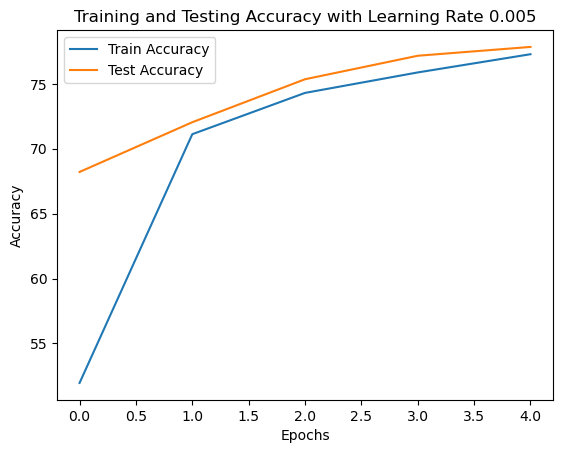

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define transformations for FashionMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
image_shape = (64, 1, 28, 28)  # Batch size, Channels, Height, Width
model = LightViT(image_shape, n_patches=7, n_blocks=2, d=8, n_heads=2, num_classes=10)

# Function to train the model
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Function to test the model
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Hyperparameters and other configurations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
epochs = 5
learning_rate = 0.005

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store the results
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

# Plotting the results
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy with Learning Rate 0.005')
plt.show()





## 5b. Model Training for FashionMNIST


Learning Rate: 0.01, Epoch: 1, Train Loss: 0.9986, Train Accuracy: 61.59%, Test Loss: 0.7400, Test Accuracy: 72.06%
Learning Rate: 0.01, Epoch: 2, Train Loss: 0.6941, Train Accuracy: 74.13%, Test Loss: 0.6526, Test Accuracy: 75.90%
Learning Rate: 0.01, Epoch: 3, Train Loss: 0.6467, Train Accuracy: 76.11%, Test Loss: 0.6661, Test Accuracy: 75.19%
Learning Rate: 0.01, Epoch: 4, Train Loss: 0.6215, Train Accuracy: 77.12%, Test Loss: 0.6961, Test Accuracy: 74.80%
Learning Rate: 0.01, Epoch: 5, Train Loss: 0.5985, Train Accuracy: 77.74%, Test Loss: 0.6350, Test Accuracy: 76.59%
Learning Rate: 0.001, Epoch: 1, Train Loss: 1.4727, Train Accuracy: 41.90%, Test Loss: 1.0540, Test Accuracy: 60.32%
Learning Rate: 0.001, Epoch: 2, Train Loss: 0.9387, Train Accuracy: 64.43%, Test Loss: 0.9378, Test Accuracy: 64.20%
Learning Rate: 0.001, Epoch: 3, Train Loss: 0.8284, Train Accuracy: 69.18%, Test Loss: 0.7974, Test Accuracy: 69.82%
Learning Rate: 0.001, Epoch: 4, Train Loss: 0.7624, Train Accuracy: 7

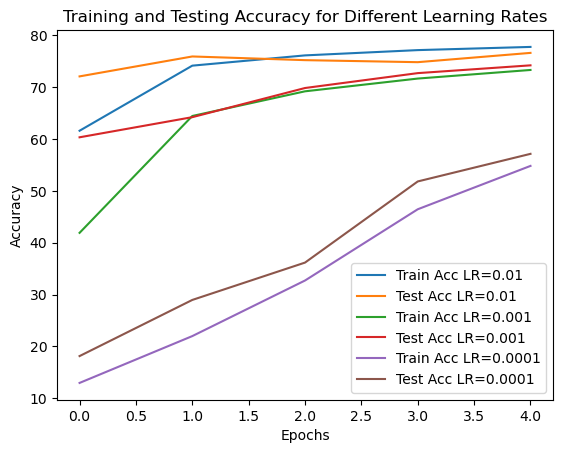

The best learning rate is 0.01


In [72]:
learning_rates = [0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    model = LightViT(image_shape, n_patches=7, n_blocks=2, d=8, n_heads=2, num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'Learning Rate: {lr}, Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    results[lr] = {
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

# Plotting the results for different learning rates
for lr in learning_rates:
    plt.plot(results[lr]['train_accuracies'], label=f'Train Acc LR={lr}')
    plt.plot(results[lr]['test_accuracies'], label=f'Test Acc LR={lr}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy for Different Learning Rates')
plt.show()

# Select the best performing model based on test accuracy
best_lr = max(results, key=lambda lr: max(results[lr]['test_accuracies']))
print(f'The best learning rate is {best_lr}')
